In [1]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix


from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [4]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [5]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (800, 800)

def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


Dataset all shape :  (5856, 800, 800)
Dataset bp shape :  (3178, 800, 800)
Dataset ration shape :  (4431, 800, 800)
Dataset bp+ratio shape :  (2502, 800, 800)


In [6]:
from sklearn.metrics import make_scorer, f1_score

def cross_val(model, load_dataset_function, scoring, nb_folds=5):
    load_dataset_function()
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    for dataset_key in res:
        mean = res[dataset_key].mean()
        std = res[dataset_key].std()
        res[dataset_key] = {"mean": mean, "std": std}
    return pd.DataFrame(res)    

def fit_and_score_each_dataset(model, scoring):
    res = {}
    
    res["all"] = (cross_val(model, use_all_dataset, scoring))
    res["ratio"] = (cross_val(model, use_ratio_dataset, scoring))
    res["black_pixel"] = (cross_val(model, use_black_pixel_dataset, scoring))
    res["ratio_black_pixel"] = (cross_val(model, use_ratio_black_pixel_dataset, scoring))
    
    return res

In [7]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

In [8]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA")
}

In [ ]:
model = make_pipeline(
    FlattenTransformer(),
    DummyClassifier(strategy="most_frequent")
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

recall :  1.0
precision :  0.7440273037542662
f1score :  0.8532289628180039


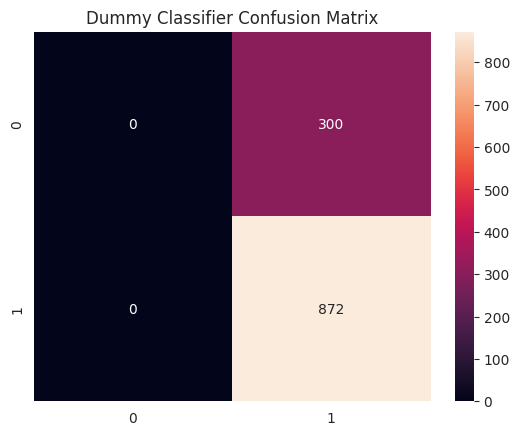

In [10]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Dummy Classifier Confusion Matrix")
plt.show()

In [9]:
#test du 03/06
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11)
)

scores = fit_and_score_each_dataset(model, general_scoring)

ValueError: If using all scalar values, you must pass an index

In [13]:
scores

{'all':       test_recall  train_recall  test_precision  train_precision   test_f1  \
 mean     0.985021      0.987713        0.900864         0.918536  0.940488   
 std      0.003808      0.001624        0.043411         0.009123  0.024391   
 
       train_f1  
 mean  0.951847  
 std   0.005066  ,
 'ratio':       test_recall  train_recall  test_precision  train_precision   test_f1  \
 mean     0.968619       0.97604        0.891351         0.917500  0.927431   
 std      0.007135       0.00287        0.051977         0.007623  0.027863   
 
       train_f1  
 mean  0.945853  
 std   0.004923  ,
 'black_pixel':       test_recall  train_recall  test_precision  train_precision   test_f1  \
 mean     0.958160      0.969279        0.868192         0.885556  0.909826   
 std      0.006105      0.001712        0.057242         0.017249  0.031823   
 
       train_f1  
 mean  0.925443  
 std   0.009434  ,
 'ratio_black_pixel':       test_recall  train_recall  test_precision  train_precision 

In [ ]:
#test du 03/06
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=3)
)

scores = fit_and_score_each_dataset(model, general_scoring)
scores

In [15]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=5)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.9777777777777777, 0.9730679156908665, 0.974...","[0.959114139693356, 0.9556313993174061, 0.9556...","[0.9470899470899471, 0.9338624338624338, 0.947...","[0.8671875, 0.89453125, 0.91796875, 0.88671875..."
train_recall,"[0.9856641310708016, 0.9897630886224043, 0.986...","[0.9748400852878465, 0.9803921568627451, 0.976...","[0.9668874172185431, 0.9728476821192052, 0.968...","[0.93359375, 0.9375, 0.9375, 0.94140625, 0.948..."
test_precision,"[0.9278579356270811, 0.9101861993428259, 0.925...","[0.9229508196721311, 0.9061488673139159, 0.912...","[0.8839506172839506, 0.863080684596577, 0.895,...","[0.8809523809523809, 0.8841698841698842, 0.876..."
train_precision,"[0.9332409972299169, 0.9306930693069307, 0.933...","[0.9288906948394962, 0.9319286871961102, 0.932...","[0.9045848822800495, 0.8957317073170732, 0.895...","[0.9122137404580153, 0.9065155807365439, 0.909..."
test_f1,"[0.9521640091116174, 0.9405772495755518, 0.949...","[0.9406850459482038, 0.9302325581395349, 0.933...","[0.9144316730523627, 0.8970775095298602, 0.920...","[0.8740157480314961, 0.8893203883495145, 0.896..."
train_f1,"[0.9587364826408651, 0.9593196314670447, 0.959...","[0.951310861423221, 0.9555463232239302, 0.9537...","[0.9346991037131882, 0.9326984126984127, 0.930...","[0.9227799227799228, 0.9217474795967355, 0.923..."


In [21]:
df["all"]["test_recall"].mean()
bla = "test_"+"recall"
df["all"][bla].mean()

KeyError: 'testrecall'

recall :  0.9850917431192661
precision :  0.9177350427350427
f1score :  0.9502212389380531


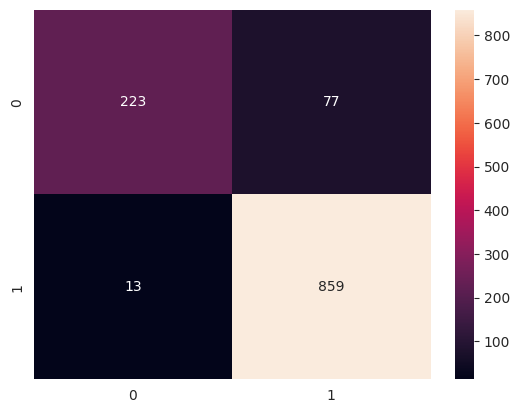

In [10]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [11]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)


   test_recall  train_recall  test_precision  train_precision   test_f1  \
0     0.985021      0.987713        0.900864         0.918536  0.940488   
1     0.985021      0.987713        0.900864         0.918536  0.940488   
2     0.985021      0.987713        0.900864         0.918536  0.940488   
3     0.985021      0.987713        0.900864         0.918536  0.940488   
4     0.985021      0.987713        0.900864         0.918536  0.940488   

   train_f1  
0  0.951847  
1  0.951847  
2  0.951847  
3  0.951847  
4  0.951847  
   test_recall  train_recall  test_precision  train_precision   test_f1  \
0     0.968619       0.97604        0.891351           0.9175  0.927431   
1     0.968619       0.97604        0.891351           0.9175  0.927431   
2     0.968619       0.97604        0.891351           0.9175  0.927431   
3     0.968619       0.97604        0.891351           0.9175  0.927431   
4     0.968619       0.97604        0.891351           0.9175  0.927431   

   train_f1  


ValueError: If using all scalar values, you must pass an index

In [14]:
print(scores)

{'all':    test_recall  train_recall  test_precision  train_precision   test_f1  \
0     0.985021      0.987713        0.900864         0.918536  0.940488   
1     0.985021      0.987713        0.900864         0.918536  0.940488   
2     0.985021      0.987713        0.900864         0.918536  0.940488   
3     0.985021      0.987713        0.900864         0.918536  0.940488   
4     0.985021      0.987713        0.900864         0.918536  0.940488   

   train_f1  
0  0.951847  
1  0.951847  
2  0.951847  
3  0.951847  
4  0.951847  , 'ratio':    test_recall  train_recall  test_precision  train_precision   test_f1  \
0     0.968619       0.97604        0.891351           0.9175  0.927431   
1     0.968619       0.97604        0.891351           0.9175  0.927431   
2     0.968619       0.97604        0.891351           0.9175  0.927431   
3     0.968619       0.97604        0.891351           0.9175  0.927431   
4     0.968619       0.97604        0.891351           0.9175  0.927431 

recall :  0.9908256880733946
precision :  0.9152542372881356
f1score :  0.9515418502202643


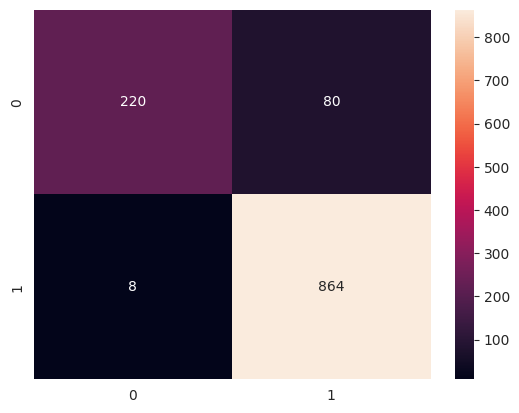

In [11]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()